In [8]:
from pathlib import Path

root_path = Path.cwd().parent
data_path = root_path / "data"

1. Loading Data...
2. Aligning Data...
   -> Processing 12185 seconds of data.
3. Extracting Features (Parallel on 8117 windows)...
   -> Done in 18.3 seconds.
   -> Samples: 8117
4. Training Model...
5. Predicting...

Overall: MSE=23.00, RMSE=4.80, R²=0.18, r=0.48, 95% CI=0.23


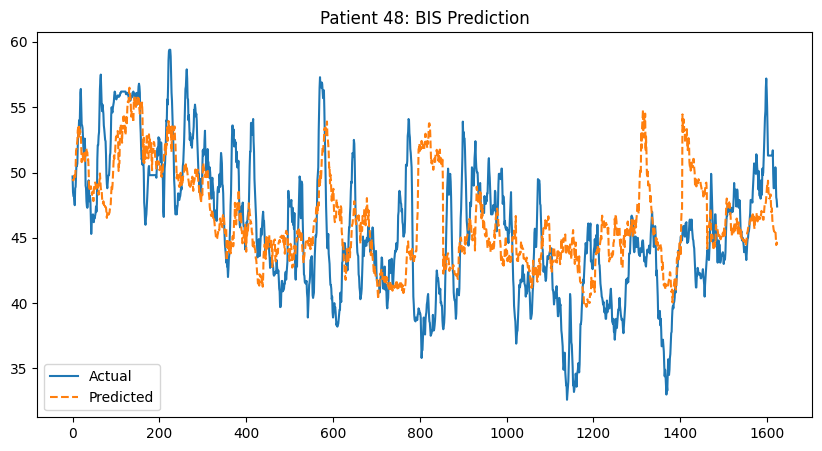

In [9]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.signal import butter, filtfilt
from scipy.stats import pearsonr, t, entropy
import time

bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}


def bandpass_filter(signal, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)


def permutation_entropy(time_series, order=3, delay=1):
    n = len(time_series)
    if n < order * delay: return 0
    # Standard PE calculation
    permutations = np.array([time_series[i:i + order * delay:delay] for i in range(n - (order - 1) * delay)])
    # Optimization: Use axis=0 unique if available (faster than string conversion)
    try:
        patterns, counts = np.unique(permutations, axis=0, return_counts=True)
    except TypeError:
        # Fallback for older numpy
        perm_strings = [str(row) for row in permutations]
        patterns, counts = np.unique(perm_strings, return_counts=True)

    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs + 1e-10))


def spike_detection(signal, threshold=3):
    if np.std(signal) == 0: return 0
    return np.sum(np.abs(signal - np.mean(signal)) > threshold * np.std(signal))


def band_features(signal, fs):
    de_sq_list = []
    spike_list = []
    for band_name in bands:
        low, high = bands[band_name]
        try:
            filtered = bandpass_filter(signal, fs, low, high)
            var = np.var(filtered)
            if var <= 0: var = 1e-10
            de = 0.5 * np.log(2 * np.pi * np.e * var)
            de_sq_list.append(de ** 2)
            spike_list.append(spike_detection(filtered))
        except:
            de_sq_list.append(0);
            spike_list.append(0)

    # PE in Delta only
    try:
        delta_sig = bandpass_filter(signal, fs, 0.5, 4)
        pe_delta = permutation_entropy(delta_sig)
    except:
        pe_delta = 0

    return de_sq_list + spike_list + [pe_delta]


def process_window_wrapper(start_idx, eeg_vals, win_size, fs):
    """Helper function for parallel processing"""
    window = eeg_vals[start_idx: start_idx + win_size]
    if len(window) < win_size or np.all(window == 0):
        return None
    return band_features(window, fs)


def trim_zero_ends(eeg, bis, fs_eeg=128, fs_bis=1):
    bis_start = next((i for i, v in enumerate(bis) if v != 0), None)
    bis_end_rev = next((i for i, v in enumerate(bis[::-1]) if v != 0), None)

    if bis_start is None or bis_end_rev is None:
        return np.array([]), np.array([])

    bis_end = len(bis) - bis_end_rev

    bis_trimmed = bis[bis_start:bis_end]

    eeg_start = int(bis_start / fs_bis * fs_eeg)
    eeg_end = int(bis_end / fs_bis * fs_eeg)
    eeg_trimmed = eeg[eeg_start:eeg_end]

    return eeg_trimmed, bis_trimmed


if __name__ == "__main__":
    fs = 128
    window_sec = 56
    step_sec = 1
    advance_sec = 60

    print("1. Loading Data...")
    try:
        df_bis = pd.read_csv(data_path / 'patient48_bis.csv')
        df_eeg = pd.read_csv(data_path / 'patient48_eeg.csv')
    except:
        print("CSV files not found.");
        exit()

    eeg_raw = df_eeg['EEG'].interpolate('linear').values
    bis_raw = df_bis['BIS'].interpolate('linear').values

    print("2. Aligning Data...")
    eeg, bis = trim_zero_ends(eeg_raw, bis_raw, fs_eeg=fs, fs_bis=1)

    if len(eeg) == 0: print("Data empty after trim."); exit()
    print(f"   -> Processing {len(bis)} seconds of data.")

    # Prepare indices for Parallel loop
    win_samples = int(window_sec * fs)
    step_samples = int(step_sec * fs)
    starts = range(0, len(eeg) - win_samples + 1, step_samples)

    print(f"3. Extracting Features (Parallel on {len(starts)} windows)...")
    t0 = time.time()

    features_raw = Parallel(n_jobs=-1)(
        delayed(process_window_wrapper)(s, eeg, win_samples, fs)
        for s in starts
    )

    # Filter Nones
    X = [f for f in features_raw if f is not None]

    advance_steps = int(advance_sec / step_sec)
    y = bis[advance_steps:]

    # Match lengths
    min_len = min(len(X), len(y))
    X = np.array(X[:min_len])
    y = np.array(y[:min_len])

    print(f"   -> Done in {time.time() - t0:.1f} seconds.")
    print(f"   -> Samples: {len(X)}")

    # Train/Test
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    print("4. Training Model...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    model = SVR(kernel='rbf')
    model.fit(X_train_scaled, y_train)

    print("5. Predicting...")
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)

    # Results
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    r, _ = pearsonr(y_test, y_pred)
    ci = 1.96 * np.std(np.array(y_pred) - np.array(y_test)) / np.sqrt(len(y_test))
    print(f"\nOverall: MSE={mse:.2f}, RMSE={rmse:.2f}, R²={r2:.2f}, r={r:.2f}, 95% CI={ci:.2f}")

    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted', linestyle='--')
    plt.legend()
    plt.title("Patient 48: BIS Prediction")
    plt.show()


--- Advanced Evaluation ---
RMSE (Error Magnitude):    4.80  (Target: <10)
MAE (Typical Error):       3.73
Pearson r (Trend Match):   0.48 (Target: >0.8)
Clinical Acceptance Rate:  95.6% (errors <= 10)


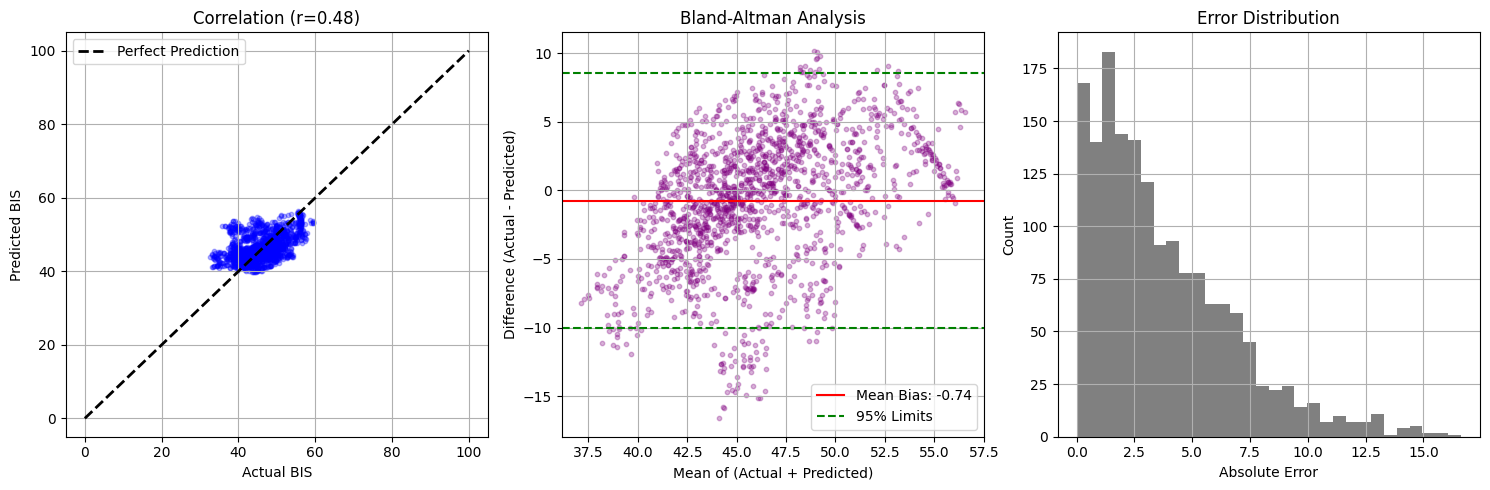

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error

pearson_r, _ = pearsonr(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

errors = np.abs(y_test - y_pred)
acceptance_rate = np.sum(errors <= 10) / len(errors) * 100

print(f"RMSE (Error Magnitude):    {rmse:.2f}")
print(f"MAE (Typical Error):       {mae:.2f}")
print(f"Pearson r (Trend Match):   {pearson_r:.2f}")
print(f"Clinical Acceptance Rate:  {acceptance_rate:.1f}%")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.3, color='blue', s=10)
plt.plot([0, 100], [0, 100], 'k--', lw=2, label='Perfect Prediction')  # Diagonal line
plt.xlabel('Actual BIS')
plt.ylabel('Predicted BIS')
plt.title(f'Correlation (r={pearson_r:.2f})')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
mean_vals = (y_test + y_pred) / 2
diff_vals = y_test - y_pred
mean_diff = np.mean(diff_vals)
std_diff = np.std(diff_vals)

plt.scatter(mean_vals, diff_vals, alpha=0.3, color='purple', s=10)
plt.axhline(mean_diff, color='red', linestyle='-', label=f'Mean Bias: {mean_diff:.2f}')
plt.axhline(mean_diff + 1.96 * std_diff, color='green', linestyle='--', label='95% Limits')
plt.axhline(mean_diff - 1.96 * std_diff, color='green', linestyle='--')
plt.xlabel('Mean of (Actual + Predicted)')
plt.ylabel('Difference (Actual - Predicted)')
plt.title('Bland-Altman Analysis')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.hist(errors, bins=30, color='gray')
plt.xlabel('Absolute Error')
plt.ylabel('Count')
plt.title('Error Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

Calculating Learning Curve.


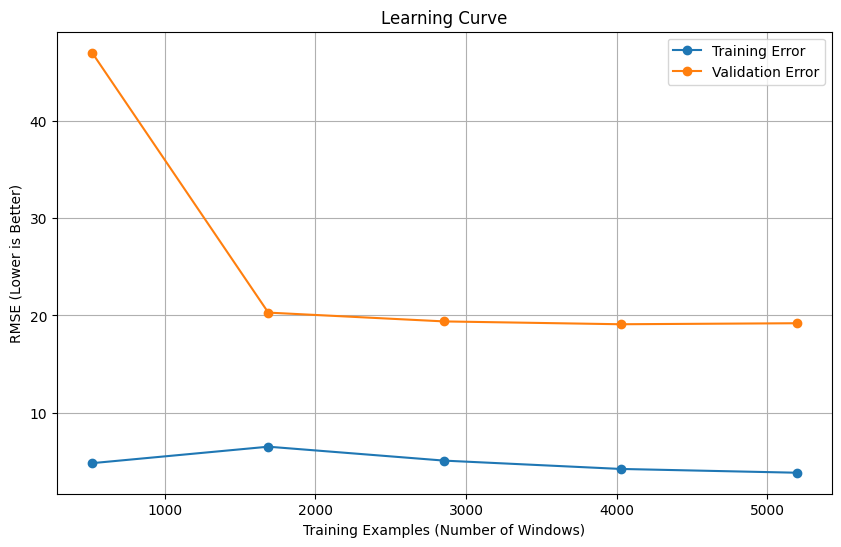

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training Error")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Validation Error")
plt.xlabel("Training Examples (Number of Windows)")
plt.ylabel("RMSE (Lower is Better)")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.show()